季節調整モデル+ローカルトレンドモデルに対するカルマン平滑化と、対数尤度の計算を通じたモデル比較を行う

# モデル

## ローカルトレンドモデル

2次の多項式モデル、線形のトレンドを掴む  

$$
x_t = 
\begin{bmatrix}
 x_{t}^2 \\
 x_{t}^1 \\
\end{bmatrix}, 
G = 
\begin{bmatrix}
 1 & 1 \\
 0 & 1 \\
\end{bmatrix},
F = 
\begin{bmatrix}
 1 & 0\\
\end{bmatrix}
W = 
\begin{bmatrix}
 w_2 & 0 \\
 0 & w_1 \\
\end{bmatrix}, 
V = V \\
x_t = G x_{t-1} + w_t, w_t \sim N(0, W) \\
y_t = F x_t + v_t, v_t \sim N(0, V)
$$

$x_t^{2}$は短時間でのレベル, $x_t^{1}$は短時間での傾きを表している

## 周期モデル

周期的な変動を捉えるモデル。今回は曜日効果を想定(s=7)

$$
x_t =
\begin{bmatrix}
 x_t^1 \\ x_t^2 \\ x_t^3 \\ x_t^4 \\ x_t^5 \\ x_t^6 \\
\end{bmatrix},
G = 
\begin{bmatrix}
 -1 & -1 & -1 & -1 & -1 & -1 \\
 1 & 0 & 0 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 0 & 0 \\
 0 & 0 & 1 & 0 & 0 & 0 \\
 0 & 0 & 0 & 1 & 0 & 0 \\
 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}, 
W = 
\begin{bmatrix}
 W & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}\\
F = 
\begin{bmatrix}
 1 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix},
V = V \\
x_t = G x_{t-1} + w_t \\
y_t = F x_t + v_t
$$

## モデル全体

$$
x_t =
\begin{bmatrix}
 x_t^{trend} \\
 x_t^{season}
\end{bmatrix},
G = 
\begin{bmatrix}
 G^{trend} & 0 \\
 0 & G^{season} \\
\end{bmatrix}, 
W = 
\begin{bmatrix}
 W^{trend} & 0 \\
 0 & W^{season} \\
\end{bmatrix}, \\
F = 
\begin{bmatrix}
 F^{trend} & F^{season} \\
\end{bmatrix},
V = V^{trend} + V^{season} \\
x_t = G x_{t-1} + w_t \\
y_t = F x_t + v_t
$$

# 実装

## ライブラリのインポート

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

np.random.seed(1234)
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

%matplotlib inline

## 既知のパラメータ、関数の設定

In [3]:
G_trend = np.array([[1, 1], [0, 1]])
F_trend = np.array([[1, 0]])
W_trend = np.diag([10, 0.1]) # [trend全体の状態誤差、trend全体の傾きに対する状態誤差]
V_trend = np.array([[8]])

In [4]:
G_season = np.array([
    [-1, -1, -1, -1, -1, -1],
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0]
])
F_season = np.array([[1, 0, 0, 0, 0, 0]])
W_season = np.diag([1, 0, 0, 0, 0, 0]) # 状態誤差は遷移する度に膨らんでいく
V_season = np.array([[2]]) # 観測誤差はYのみに影響

In [5]:
F = np.block([F_trend, F_season])
G = np.block([[G_trend, np.zeros((2, 6))], [np.zeros((6, 2)), G_season]])
W = np.block([[W_trend, np.zeros((2, 6))], [np.zeros((6, 2)), W_season]])
V = V_trend + V_season # trendの観測誤差とseasonの観測誤差が合わさる

## 仮想データの作成

線形に伸びるトレンド+曜日効果  
初期状態とトレンドの傾き、時点数を設定する

In [78]:
T = 100 # 時点数
x0_trend = np.array([100, 2]) # [初期状態の値、傾き], それぞれの値と対応する分散の大きさに注意
x0_season = np.array([-10, 10, 40, 50, 10, -40])
x0 = np.concatenate([x0_trend, x0_season], axis=0)

In [79]:
X = np.zeros((T, 8))
Y = np.zeros(T)

In [80]:
w = np.random.multivariate_normal(np.zeros(8), W, T)
v = np.random.normal(0, V.flatten()**(1/2), T).reshape(-1,1)

In [81]:
for t in range(T): # 色々考えたけど、行ベクトルでarrayを保存しているので、極力1次元arrayで処理した方が、列ベクトル行ベクトルを気にしなくて済む
    if t == 0:
        X[t] = G @ x0 + w[t]
        Y[t] = F @ X[t] + v[t]
    else:
        X[t] = G @ X[t-1] + w[t]
        Y[t] = F @ X[t] + v[t]

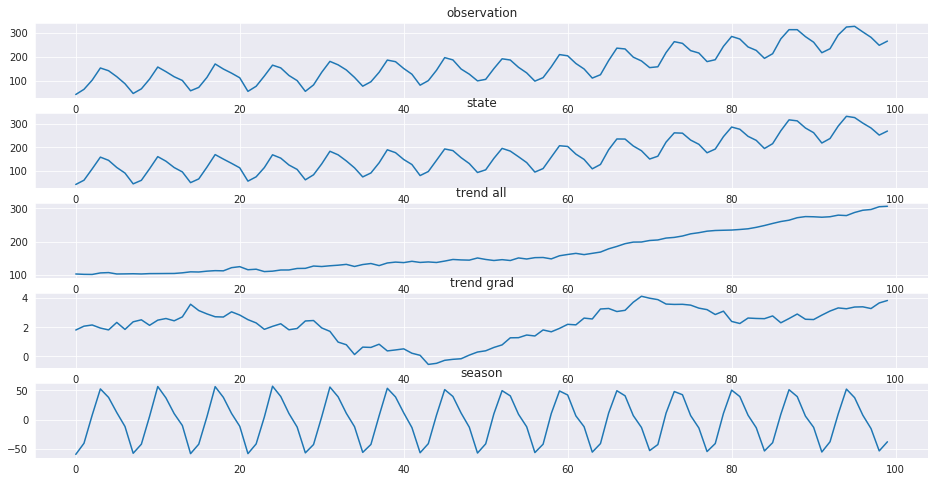

In [82]:
fig, axes = plt.subplots(nrows=5, figsize=(16, 8))
axes[0].plot(Y.flatten())
axes[1].plot(X[:,0] + X[:,2])
axes[2].plot(X[:,0])
axes[3].plot(X[:,1])
axes[4].plot(X[:,2])

axes[0].set_title("observation")
axes[1].set_title("state")
axes[2].set_title("trend all")
axes[3].set_title("trend grad")
axes[4].set_title("season")
plt.show()

いい感じの仮想データが出来た  
初期状態の値と、対応する分散パラメータをうまく調整する必要がある  
ローカルレベルモデルと比べて、trendの変化のスパンが大きい、短期的な変動があまり影響しないデータに使えそう

# カルマン平滑化の実行

In [83]:
# 自作関数の初期引数は、関数を定義した際に存在する変数を参照する
# 自作関数定義語に参照変数を上書きしても、自作関数内の値は上書きされない
def kalman_filter(m, C, y, G=G, F=F, W=W, V=V):
    """
    Kalman Filter
    m: 時点t-1のフィルタリング分布の平均
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    """
    a = G @ m
    R = G @ C @ G.T + W
    f = F @ a
    Q = F @ R @ F.T + V
    # 逆行列と何かの積を取る場合は、invよりsolveを使った方がいいらしい
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    # K = R @ F.T @ np.linalg.inv(Q)
    m = a + K @ (y - f)
    C = R - K @ F @ R
    return m, C, a, R, f, Q

In [84]:
def kalman_smoothing(s, S, m, C, a, R, G=G, W=W):
    """
    Kalman smoothing
    """
    # 平滑化利得の計算
    A = np.linalg.solve(R, C @ G.T)
    # A = C @ G.T @ np.linalg.inv(R)
    # 状態の更新
    s = m + A @ (s - a)
    S = C + A @ (S - R) @ A.T
    return s, S

In [85]:
# 結果を格納するarray
m_result = np.zeros((T, 8))
C_result = np.zeros((T, 8, 8))
a_result = np.zeros((T, 8))
R_result = np.zeros((T, 8, 8))
f_result = np.zeros((T))
Q_result = np.zeros((T))
s_result = np.zeros((T, 8))
S_result = np.zeros((T, 8, 8))

In [86]:
# W_trend_test = np.diag([10000000000, 1000000000]) # [trend全体の状態誤差、trend全体の傾きに対する状態誤差]
# V_trend_test = np.array([[8000000000]])
# W_season_test = np.diag([1000000000, 0, 0, 0, 0, 0]) # 状態誤差は遷移する度に膨らんでいく
# V_season_test = np.array([[2000000000]]) # 観測誤差はYのみに影響
# W_test = np.block([[W_trend_test, np.zeros((2, 6))], [np.zeros((6, 2)), W_season_test]])
# V_test = V_trend_test + V_season_test # trendの観測誤差とseasonの観測誤差が合わさる

In [99]:
m0 = np.zeros(8)
C0 = np.diag([1e1]*8)
# m0 = np.mean(s_result, axis=0)
# C0 = np.mean(S_result, axis=0)

for t in range(T):
    if t == 0:
        m_result[t], C_result[t], a_result[t], R_result[t], f_result[t], Q_result[t] = kalman_filter(m0, C0, Y[t], W=W, V=V)
    else:
        m_result[t], C_result[t], a_result[t], R_result[t], f_result[t], Q_result[t] = kalman_filter(m_result[t-1], C_result[t-1], Y[t], W=W, V=V)
        
for t in range(T):
    t = T - t - 1
    if t == T - 1:
        s_result[t], S_result[t] = m_result[t], C_result[t]
    else:
        s_result[t], S_result[t] = kalman_smoothing(s_result[t+1], S_result[t+1], m_result[t], C_result[t], a_result[t+1], R_result[t+1], W=W)

## 結果の描画

$$
x_t^{all} = x_t^{trend} + x_t^{season} \\
Var(x_t^{all}) = Var(x_t^{trend}) + Var(x_t^{season}) + 2 Cov(x_t^{trend}, x_t^{season})
$$

In [100]:
lower = 50
upper = 450
legend_loc = "upper left"

In [101]:
s_all = s_result[:,0] + s_result[:,2]
S_all = S_result[:,0,0] + S_result[:,2,2] + 2 * S_result[:,0,2]

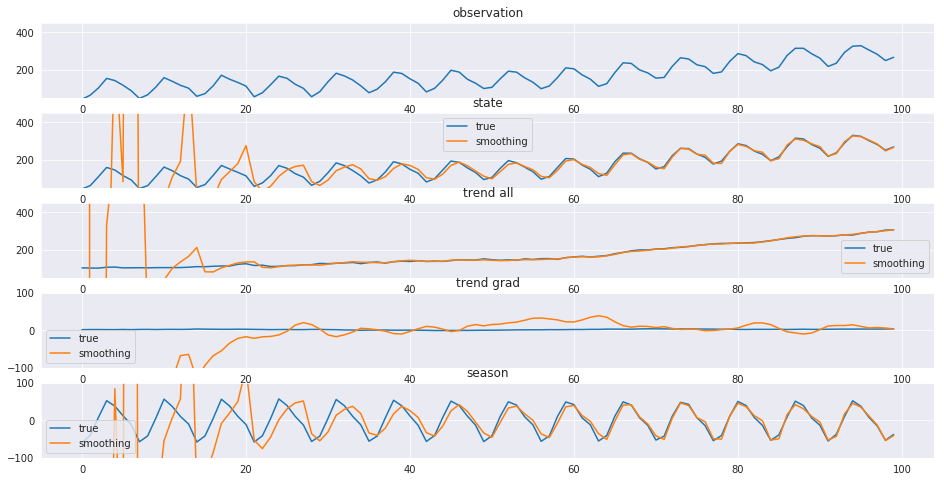

In [103]:
fig, axes = plt.subplots(nrows=5, figsize=(16, 8))
axes[0].plot(Y.flatten())
axes[1].plot(X[:,0] + X[:,2], label="true")
axes[1].plot(s_all, label="smoothing")
axes[2].plot(X[:,0], label="true")
axes[2].plot(s_result[:,0], label="smoothing")
axes[3].plot(X[:,1], label="true")
axes[3].plot(s_result[:,1], label="smoothing")
axes[4].plot(X[:,2], label="true")
axes[4].plot(s_result[:,2], label="smoothing")

axes[0].set_ylim(50, 450)
axes[1].set_ylim(50, 450)
axes[2].set_ylim(50, 450)
axes[3].set_ylim(-100, 100)
axes[4].set_ylim(-100, 100)

axes[0].set_title("observation")
axes[1].set_title("state")
axes[2].set_title("trend all")
axes[3].set_title("trend grad")
axes[4].set_title("season")

axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
plt.show()

周期成分を持ったモデルなので、雑に初期状態を決めると当てはまりが良くない(特に平均)

trendの傾きはあまり当てはまりが良くない(モデルの精度には直接関係ないけど)

最後に、負の対数尤度を求めてモデルの当てはまり具合を確かめる  
状態が安定した時点20以降を用いて計算する

In [17]:
def nllloss(y, f, Q):
    """
    Negative Log Likelihood Loss, 負の対数尤度
    正規分布を仮定
    """
    return np.sum(np.log(Q)/2 + (y - f)**2/Q)

In [18]:
nllloss(Y, f_result, Q_result)

694.2140338869592

## ローカルレベルモデルの適用、モデル比較

ローカルトレンドモデルの部分を、ローカルレベルモデルに変えてみる  
多分、線形のトレンドが無くなってよりぐにゃぐにゃした図になる

In [23]:
G_level = np.array([[1]])
F_level = np.array([[1]])
W_level = np.diag([10]) # [trend全体の状態誤差、trend全体の傾きに対する状態誤差]
V_level = np.array([[8]])

In [24]:
F = np.block([F_level, F_season])
G = np.block([[G_level, np.zeros((1, 6))], [np.zeros((6, 1)), G_season]])
W = np.block([[W_level, np.zeros((1, 6))], [np.zeros((6, 1)), W_season]])
V = V_level + V_season # trendの観測誤差とseasonの観測誤差が合わさる

In [25]:
# 結果を格納するarray
m_level = np.zeros((T, 7))
C_level = np.zeros((T, 7, 7))
a_level = np.zeros((T, 7))
R_level = np.zeros((T, 7, 7))
f_level = np.zeros((T))
Q_level = np.zeros((T))
s_level = np.zeros((T, 7))
S_level = np.zeros((T, 7, 7))

In [32]:
m0 = np.zeros(7)
C0 = np.diag([1e7]*7)
# m0 = np.mean(s_level, axis=0)
# C0 = np.mean(S_level, axis=0)

# kalman_filterとkalman_smoothingのcellを再度実行しないと、初期引数が更新されない
for t in range(T):
    if t == 0:
        m_level[t], C_level[t], a_level[t], R_level[t], f_level[t], Q_level[t] = kalman_filter(m0, C0, Y[t])
    else:
        m_level[t], C_level[t], a_level[t], R_level[t], f_level[t], Q_level[t] = kalman_filter(m_level[t-1], C_level[t-1], Y[t])
        
for t in range(T):
    t = T - t - 1
    if t == T - 1:
        s_level[t], S_level[t] = m_level[t], C_level[t]
    else:
        s_level[t], S_level[t] = kalman_smoothing(s_level[t+1], S_level[t+1], m_level[t], C_level[t], a_level[t+1], R_level[t+1])

In [34]:
lower = 50
upper = 450
legend_loc = "upper left"

In [37]:
s_all = s_level[:,0] + s_level[:,1]
S_all = S_level[:,0,0] + S_level[:,1,1] + 2 * S_level[:,0,1]

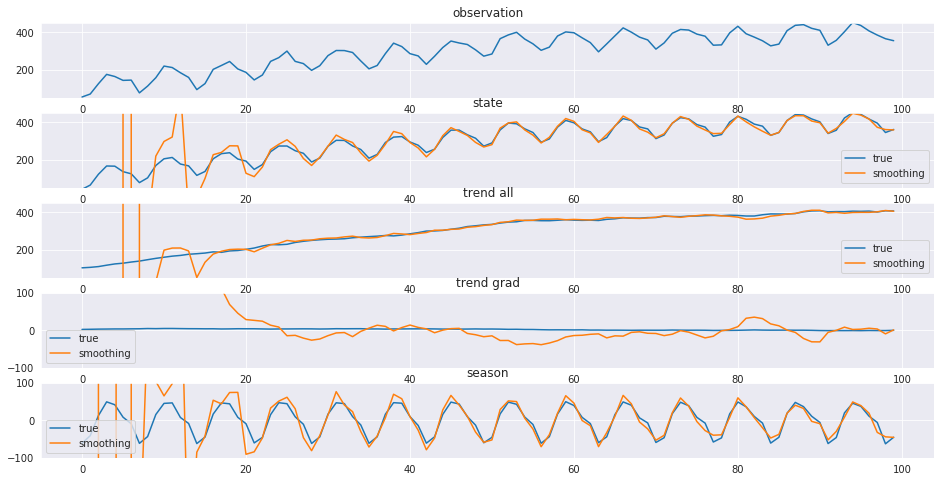

In [38]:
fig, axes = plt.subplots(nrows=5, figsize=(16, 8))
axes[0].plot(Y.flatten())
axes[1].plot(X[:,0] + X[:,2], label="true")
axes[1].plot(s_all, label="smoothing")
axes[2].plot(X[:,0], label="true")
axes[2].plot(s_result[:,0], label="smoothing")
axes[3].plot(X[:,1], label="true")
axes[3].plot(s_result[:,1], label="smoothing")
axes[4].plot(X[:,2], label="true")
axes[4].plot(s_result[:,2], label="smoothing")

axes[0].set_ylim(50, 450)
axes[1].set_ylim(50, 450)
axes[2].set_ylim(50, 450)
axes[3].set_ylim(-100, 100)
axes[4].set_ylim(-100, 100)

axes[0].set_title("observation")
axes[1].set_title("state")
axes[2].set_title("trend all")
axes[3].set_title("trend grad")
axes[4].set_title("season")

axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
plt.show()

周期成分を持ったモデルなので、雑に初期状態を決めると当てはまりが良くない(特に平均)

trendの傾きはあまり当てはまりが良くない(モデルの精度には直接関係ないけど)

最後に、負の対数尤度を求めてモデルの当てはまり具合を確かめる  
状態が安定した時点20以降を用いて計算する

In [18]:
nllloss(Y, f_result, Q_result)

694.2140338869592

In [39]:
nllloss(Y, f_level, Q_level)

790.3412288810027

負の対数尤度が大きくなった  
つまり、ローカルレベルモデルより、ローカルトレンドモデルの方が当てはまりが良い